# Simple Algorithms for Peak Detection in Time-Series

This notebook implements and tests the peak detection methods described in Girish Palshikar's paper ["Simple Algorithms for Peak Detection in Time-Series"](https://www.researchgate.net/publication/228853276_Simple_Algorithms_for_Peak_Detection_in_Time-Series).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import scienceplots

# Utilitary functions
import utils

# Update modules without restarting the kernel
importlib.reload(utils)

# Plots style
plt.style.use(['grid', 'notebook', 'science'])
plt.rcParams["figure.figsize"] = (10,6)

---

# Testing on the data used in the article

## 1. Sunspots (yearly)

In [2]:
sunspots = pd.read_csv('files/sunspots.csv', index_col=0)

### Calculate the spikiness metrics for the sunspots dataset

In [85]:
# Parameters used in the paper
k_sunspots = 5
h_sunspots = 1.5
bandwidth_sunspots = 5
#
s1_sunspots = utils.s1_metric(sunspots, k_sunspots)
s2_sunspots = utils.s2_metric(sunspots, k_sunspots)
s3_sunspots = utils.s3_metric(sunspots, k_sunspots)
s4_sunspots = utils.s4_metric(sunspots, k_sunspots, bandwidth=bandwidth_sunspots, kde_kernel='gaussian')
s5_sunspots_is_outlier, _ = utils.s5_metric(sunspots, k_sunspots, method='parametric', n_std=h_sunspots)

### Identify the peaks based on the data distribution

In [86]:
# Get S1 mean and standard deviation
s1_sunspots_mean = np.mean(s1_sunspots, axis=0)
s1_sunspots_std = np.std(s1_sunspots)
#
# Get S2 mean and standard deviation
s2_sunspots_mean = np.mean(s2_sunspots, axis=0)
s2_sunspots_std = np.std(s2_sunspots)
#
# Get S3 mean and standard deviation
s3_sunspots_mean = np.mean(s3_sunspots, axis=0)
s3_sunspots_std = np.std(s3_sunspots)
#
# Get S4 mean and standard deviation
s4_sunspots_mean = np.mean(s4_sunspots, axis=0)
s4_sunspots_std = np.std(s4_sunspots)


# Get peak indexes for each metric (h standard deviations above the mean)
#
# S1
s1_is_peak = np.where(s1_sunspots > s1_sunspots_mean + h_sunspots*s1_sunspots_std, True, False)
s1_peak_indexes = [i for (i, value) in enumerate(s1_is_peak) if value]
#
# S2
s2_is_peak = np.where(s2_sunspots > s2_sunspots_mean + h_sunspots*s2_sunspots_std, True, False)
s2_peak_indexes = [i for (i, value) in enumerate(s2_is_peak) if value]
#
# S3
s3_is_peak = np.where(s3_sunspots > s3_sunspots_mean + h_sunspots*s3_sunspots_std, True, False)
s3_peak_indexes = [i for (i, value) in enumerate(s3_is_peak) if value]
#
# S4
s4_is_peak = np.where(s4_sunspots > s4_sunspots_mean + h_sunspots*s4_sunspots_std, True, False)
s4_peak_indexes = [i for (i, value) in enumerate(s4_is_peak) if value]
#
# S5 (doesn't verify if the peaks are above the mean, because it's already done in the metric)
s5_peak_indexes = [i for (i, value) in enumerate(s5_sunspots_is_outlier.values.flatten()) if value]

### Avoid identifying two points too next to each other as peaks

In [89]:
s1_peak_indexes = utils.delete_adjacent_peaks(pd.DataFrame(s1_peak_indexes), sunspots, k_sunspots).values.flatten()
s2_peak_indexes = utils.delete_adjacent_peaks(pd.DataFrame(s2_peak_indexes), sunspots, k_sunspots).values.flatten()
s3_peak_indexes = utils.delete_adjacent_peaks(pd.DataFrame(s3_peak_indexes), sunspots, k_sunspots).values.flatten()
s4_peak_indexes = utils.delete_adjacent_peaks(pd.DataFrame(s4_peak_indexes), sunspots, k_sunspots).values.flatten()
s5_peak_indexes = utils.delete_adjacent_peaks(pd.DataFrame(s5_peak_indexes), sunspots, k_sunspots).values.flatten()

### Plot the identified peaks

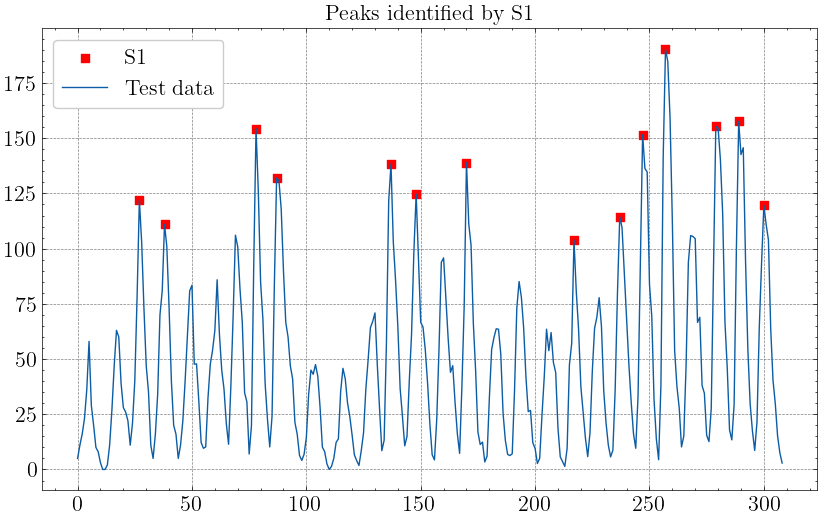

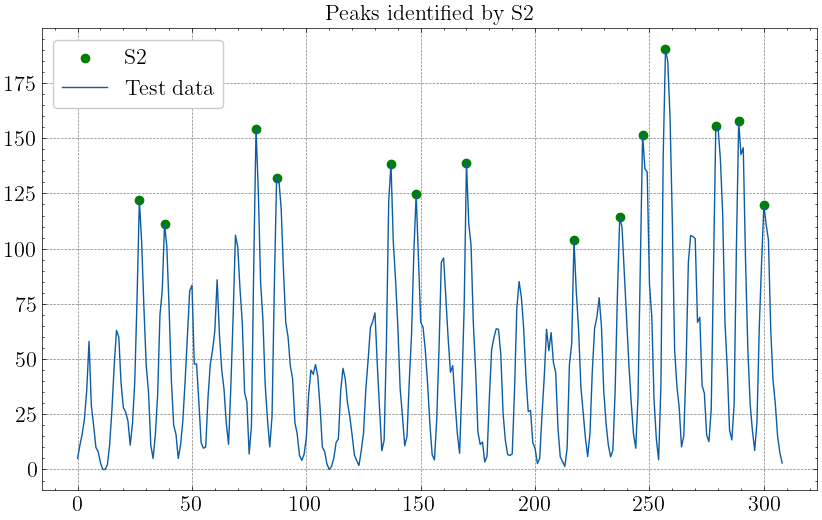

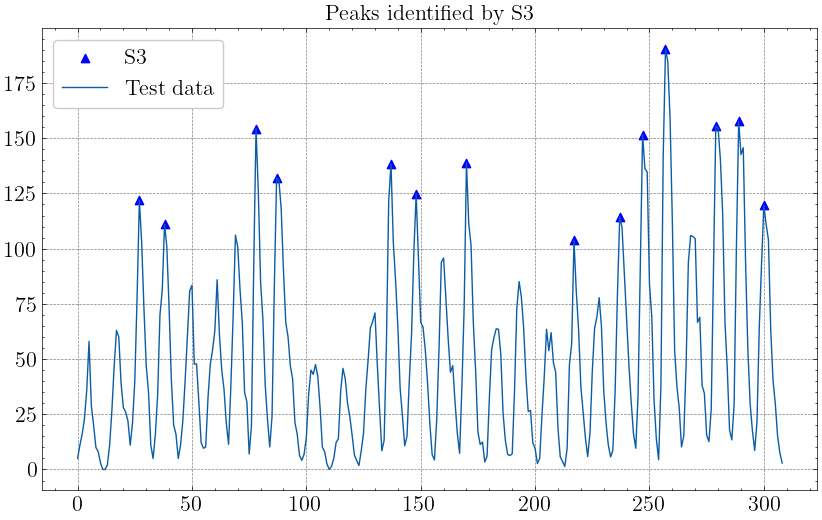

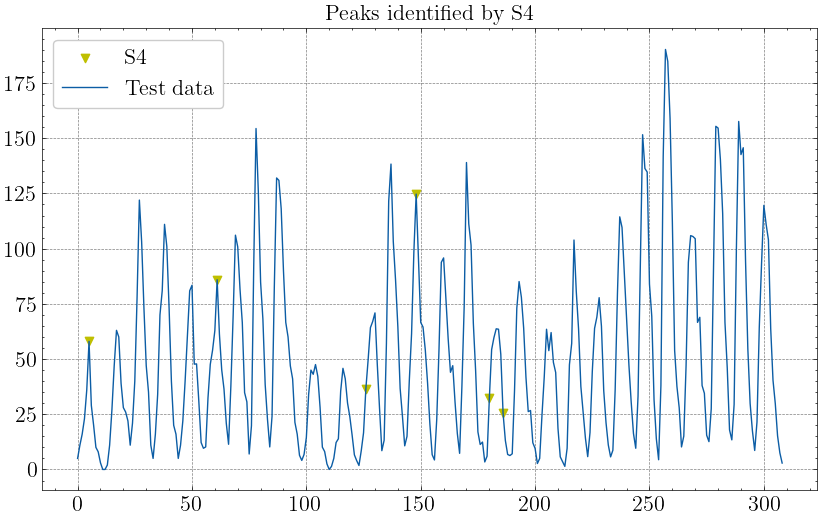

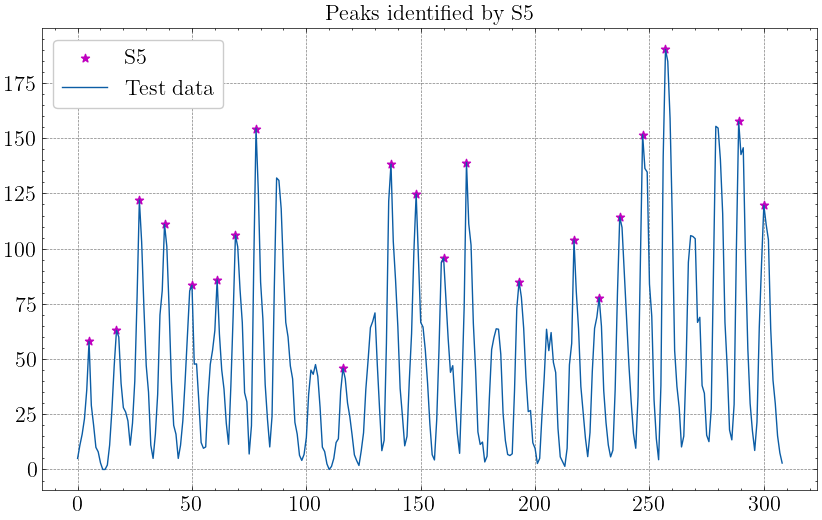

In [90]:
# Mark the peaks in the time series for each metric
#
# S1
plt.scatter(s1_peak_indexes, sunspots.values[s1_peak_indexes], marker='s', color='r', label='S1')
#
# Plot the time series with the peaks identified
plt.plot(sunspots.values, label='Test data')
plt.title(f'Peaks identified by S1')
plt.legend(frameon=True)
plt.show()
#
# S2
plt.scatter(s2_peak_indexes, sunspots.values[s2_peak_indexes], marker='o', color='g', label='S2')
#
# Plot the time series with the peaks identified
plt.plot(sunspots.values, label='Test data')
plt.title(f'Peaks identified by S2')
plt.legend(frameon=True)
plt.show()
#
# S3
plt.scatter(s3_peak_indexes, sunspots.values[s3_peak_indexes], marker='^', color='b', label='S3')
#
# Plot the time series with the peaks identified
plt.plot(sunspots.values, label='Test data')
plt.title(f'Peaks identified by S3')
plt.legend(frameon=True)
plt.show()
#
# S4
plt.scatter(s4_peak_indexes, sunspots.values[s4_peak_indexes], marker='v', color='y', label='S4')
#
# Plot the time series with the peaks identified
plt.plot(sunspots.values, label='Test data')
plt.title(f'Peaks identified by S4')
plt.legend(frameon=True)
plt.show()
#
# S5
plt.scatter(s5_peak_indexes, sunspots.values[s5_peak_indexes], marker='*', color='m', label='S5')
#
# Plot the time series with the peaks identified
plt.plot(sunspots.values, label='Test data')
plt.title(f'Peaks identified by S5')
plt.legend(frameon=True)
plt.show()